[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Olesik_et_al_2022/demo_make_plots.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Olesik_et_al_2022/demo_make_plots.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Olesik_et_al_2022/demo_make_plots.ipynb)

see [Olesik et al. 2022](https://doi.org/10.5194/gmd-15-3879-2022)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PyMPDATA_examples.Olesik_et_al_2022.analysis import compute_figure_data, rel_disp, third_moment
from PyMPDATA_examples.Olesik_et_al_2022.equilibrium_drop_growth import PdfEvolver
from PyMPDATA_examples.Olesik_et_al_2022.plotter import Plotter
from PyMPDATA_examples.Olesik_et_al_2022.coordinates import x_id, x_p2, x_log_of_pn
from PyMPDATA_examples.Olesik_et_al_2022.settings import default_opt_set, colors, default_mixing_ratios_g_kg, option_string

In [3]:
plot_steps = [0, 2, 5]
def compute_and_plot(psi_coord, grid_layout, n_bins, GC_max, variants, plots, filename):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=NumbaExperimentalFeatureWarning)
        results, settings = compute_figure_data(
            psi_coord=psi_coord, 
            grid_layouts=(grid_layout,),
            nr=n_bins,
            GC_max = GC_max,
            opt_set=tuple(default_opt_set[variant] for variant in variants)
        )
    return_value = {}
    for _, result in results.items():
        out_steps = result['grid']['out_steps']
        dt = result['grid']['dt']
        plotter = Plotter(settings, plots=plots)
        for opt_i, opts in enumerate(result['numerical']):
            variant = variants[opt_i]
            plot_data = result['numerical'][opts]
            for i, out_step in enumerate(out_steps):
                mnorm = settings.mixing_ratios[i]
                t = out_step * dt
                linewidth = 1.5
                if opt_i == 0 and i in plot_steps:
                    plotter.pdf_curve(PdfEvolver(settings.pdf, settings.drdt, t), mnorm)
                    plotter.pdf_histogram(
                        result['grid']['r'],
                        result['analytical'][i],
                        bin_boundaries = result['grid']['rh'],
                        label='discretised analytical solution (actual dotted)', 
                        mnorm=mnorm,
                        color='black',
                        linewidth = linewidth
                    )
                    
                opts = option_string(opts)

                    
                if variant not in return_value:
                    return_value[variant] = {'R_d': [], 'R_m': [], 'label': opts}

                if i in [0, 2, 5]: 
                    plotter.pdf_histogram(
                        result['grid']['r'],
                        plot_data[i], 
                        label=opts, 
                        bin_boundaries=result['grid']['rh'],
                        linewidth = linewidth,
                        mnorm=mnorm, color = colors[variant], fill=False
                    )
                
                dp_dr = psi_coord.dx_dr(result['grid']['r'])
                numeric_rel_d = rel_disp(result['grid']['rh'], plot_data[i]/dp_dr, psi_coord)
                analytic_rel_d = rel_disp(result['grid']['rh'], result['analytical'][i]/dp_dr, psi_coord)
                dispersion_ratio = (numeric_rel_d / analytic_rel_d - 1) * 100
                return_value[variant]['R_d'].append(dispersion_ratio)
                                
                numeric_mass = third_moment(result['grid']['rh'], plot_data[i]/dp_dr, psi_coord, normalised=False)
                analytic_mass = third_moment(result['grid']['rh'], result['analytical'][i]/dp_dr, psi_coord, normalised=False)
                mass_ratio = (numeric_mass / analytic_mass - 1) * 100
                return_value[variant]['R_m'].append(mass_ratio)

        pyplot.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center')
        show_plot(filename)
    return return_value

In [4]:
n_bins = 75
plot_setup_radius_square_mass_doubling = {"psi_coord":x_p2(), "grid_layout":x_log_of_pn(r0=1, base=2), "GC_max":.26,"n_bins":n_bins}
plot_setup_radius_linear = {"psi_coord":x_id(), "grid_layout":x_id(), "GC_max":.07, "n_bins":n_bins}
plot_setup_default = plot_setup_radius_square_mass_doubling
table_data = []

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:   14.3s


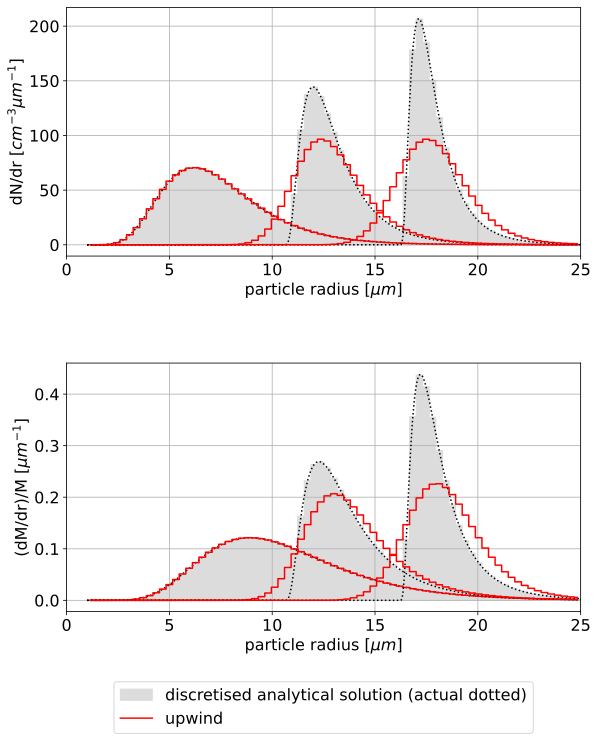

In [5]:
compute_and_plot(**plot_setup_radius_linear, variants=('a',), plots=['n','m'],  filename = 'fig_upwindb.pdf');

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    0.1s


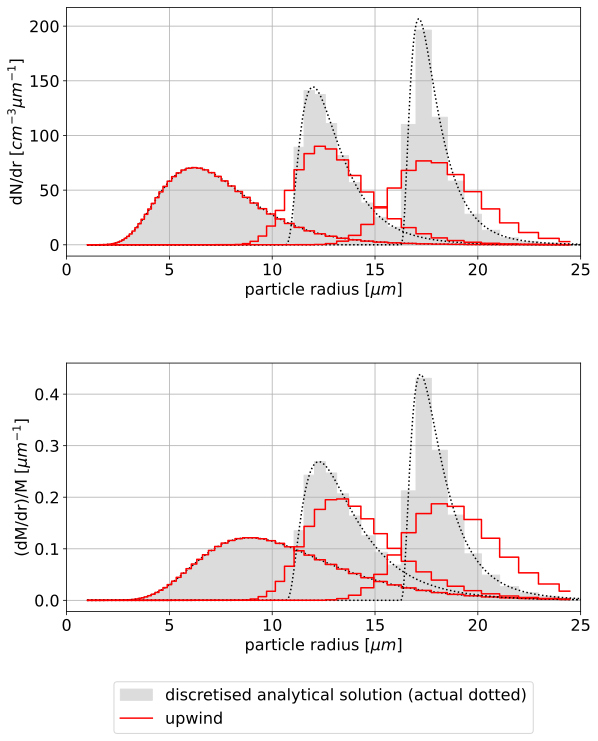

In [6]:
table_data.append(compute_and_plot(**plot_setup_default, variants=('a',), plots=['n','m'], filename = 'fig_upwinda.pdf'))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:   25.9s finished


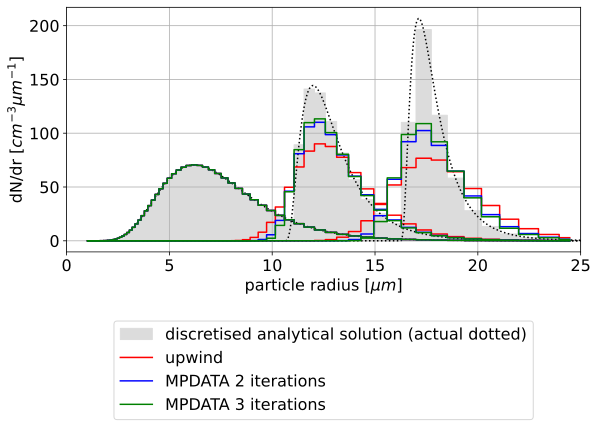

In [7]:
table_data.append(compute_and_plot(**plot_setup_default, variants=('a','b','g'), plots=['n'], filename = 'fig_mpdatas.pdf'))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   13.1s finished


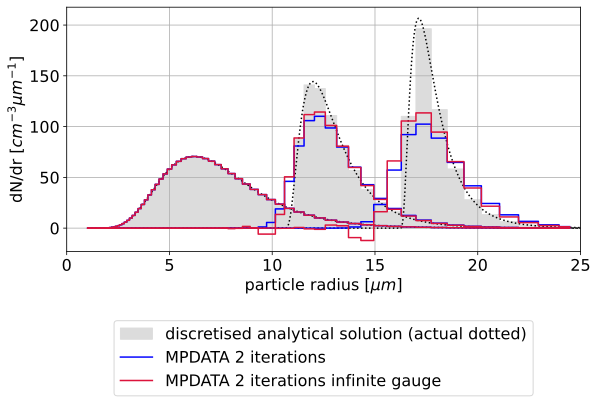

In [8]:
table_data.append(compute_and_plot(**plot_setup_default, variants=('b', 'c'), plots=['n'], filename = 'fig_iga.pdf'))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   23.1s finished


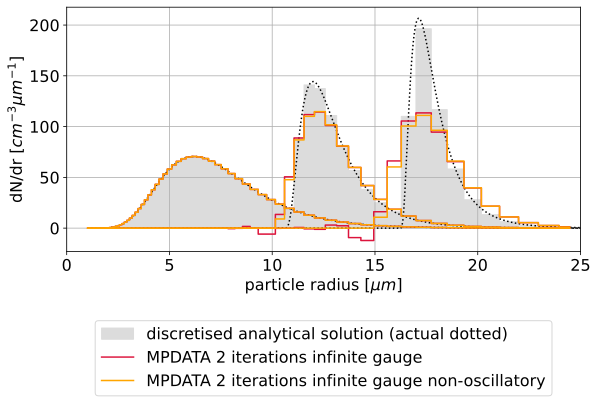

In [9]:
table_data.append(compute_and_plot(**plot_setup_default, variants=('c','d'), plots=['n'], filename = 'fig_iga_fct.pdf'))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   22.2s finished


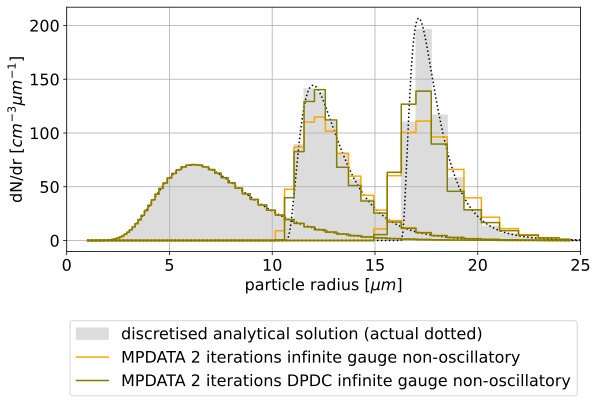

In [10]:
table_data.append(compute_and_plot(**plot_setup_default, variants=('d','e'), plots=['n'], filename = 'fig_iga_fct_dpdc.pdf'))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   13.7s finished


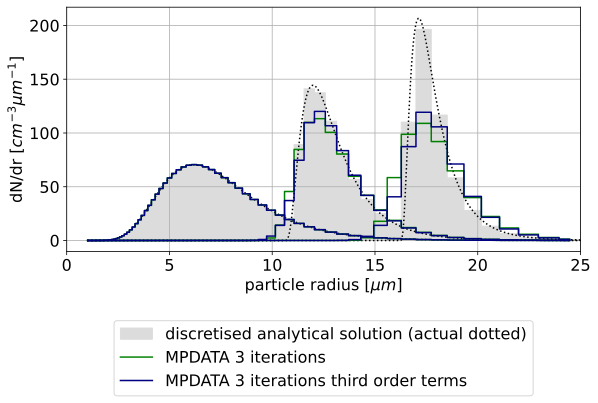

In [11]:
table_data.append(compute_and_plot(**plot_setup_default, variants=('g','f'), plots=['n'], filename = 'fig_tot.pdf'))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:   23.4s finished


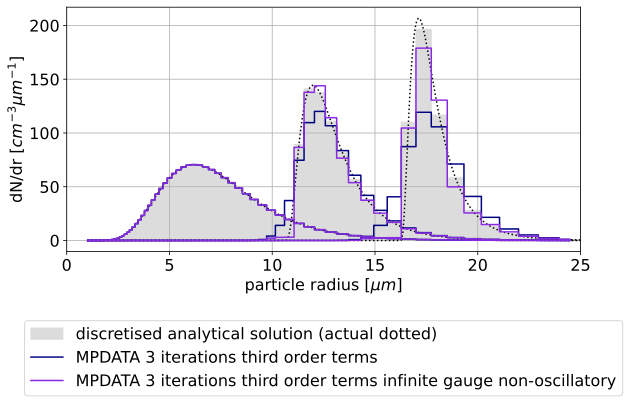

In [12]:
table_data.append(compute_and_plot(**plot_setup_default, variants=('f','h'), plots=['n'], filename = 'fig_multiopt.pdf'))

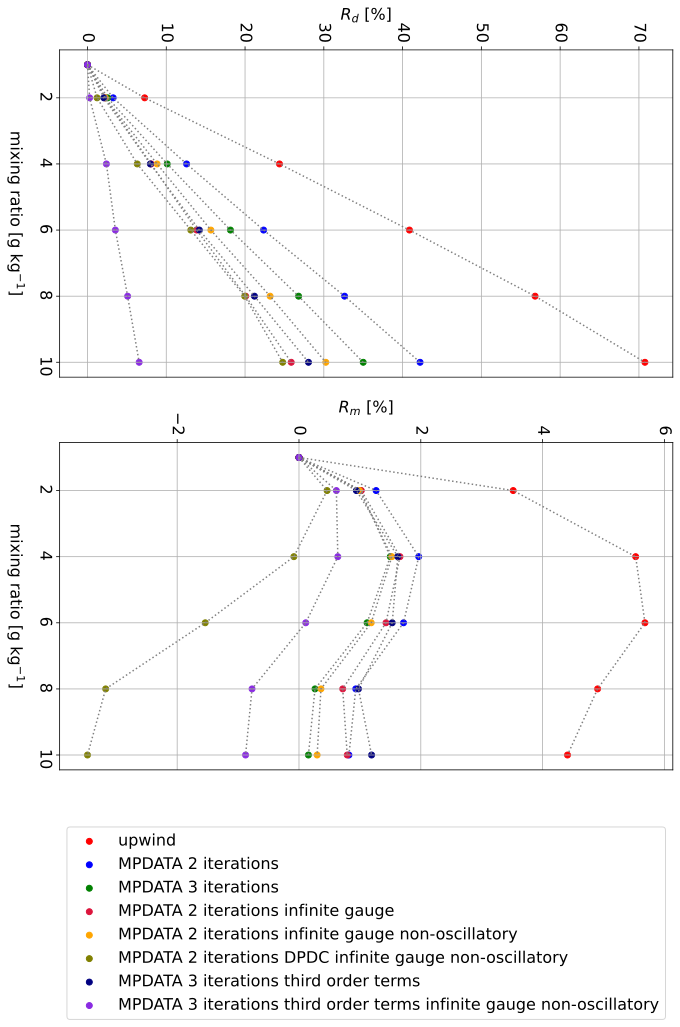

In [13]:
plot_data = {}
for datum in table_data:
    for key, value in datum.items():
        plot_data[key] = value
        
pyplot.rcParams['xtick.bottom'] = pyplot.rcParams['xtick.labelbottom'] = False
pyplot.rcParams['xtick.top'] = pyplot.rcParams['xtick.labeltop'] = True
        
def plot_measures(measure, ax, legend=False): 
    for variant, values in plot_data.items():
        Y = default_mixing_ratios_g_kg
        X = tuple(x.magnitude for x in values[measure])
        ax.scatter(X, Y, label=values['label'], color=colors[variant])
        ax.plot(X, Y, color='gray', linestyle='dotted')
    ax.grid()
    ax.invert_yaxis()
    ax.set_xlabel(f'${measure}$ [%]', labelpad=-370)
    ax.set_ylabel('mixing ratio [g kg$^{-1}$]', rotation=270, labelpad=30)
    
    for tl in ax.get_xticklabels():
        tl.set_rotation(-90)
    for tl in ax.get_yticklabels():
        tl.set_rotation(-90)

    if legend:
        pyplot.legend(bbox_to_anchor=(+0.5, -0.15), loc='upper center')
fig, axs = pyplot.subplots(2,1, figsize=(11,13))

plot_measures('R_d', axs[0])
plot_measures('R_m', axs[1], legend=True)

show_plot('measures.pdf')